In [302]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import os
import re
from string import punctuation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [303]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"\n\n", " \n\n", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", text)
    
    return text

In [304]:
with open('poems.txt',  encoding='utf8') as f:
    poems = f.readlines()
    poems = ''.join(str(e) for e in poems)
    poems = clean_text(poems)

In [305]:
vocab = Counter(poems.split(' '))

In [306]:
word2int = {w: i for i, w in enumerate(vocab)}
int2word = {i: w for i, w in enumerate(vocab)}

In [307]:
pickle.dump(word2int, open('word2int.pickle', 'wb'))
pickle.dump(int2word, open('int2word.pickle', 'wb'))

In [308]:
encoded_text = np.array([word2int[w] for w in vocab])

In [309]:
word_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [310]:
for word in word_dataset.take(10):
    print(word.numpy(), int2word[word.numpy()])

0 she
1 could
2 not
3 help
4 but
5 sting
6 my
7 finger,
8 

clinging
9 a


In [311]:
sequence_length = 20
BATCH_SIZE = 32
EPOCHS = 15

In [312]:
sequences = word_dataset.batch(2*sequence_length + 1, drop_remainder = True)

In [313]:
for sequence in sequences.take(1):
    print(' '.join([int2word[i] for i in sequence.numpy()]))

she could not help but sting my finger, 

clinging a moment before i flung her 

to the ground. gold is true, trick 

evening light plays on roses. 

she curls into herself, stinger twitching, 

gilt wings folded. whole life just few weeks,


In [314]:
def split_sample(sample):
    ds = tf.data.Dataset.from_tensors((sample[:sequence_length], sample[sequence_length]))
    for i in range(1, (len(sample)-1) // 2):
        input_ = sample[i: i+sequence_length]
        target = sample[i+sequence_length]
        other_ds = tf.data.Dataset.from_tensors((input_, target))
        ds = ds.concatenate(other_ds)
    return ds

In [315]:
dataset = sequences.flat_map(split_sample)

In [316]:
def one_hot_samples(input_, target):
    return tf.one_hot(input_, len(vocab)), tf.one_hot(target, len(vocab))

In [317]:
dataset = dataset.map(one_hot_samples)

In [318]:
for element in dataset.take(1):
    print('Input:', ' '.join([int2word[np.argmax(word_vector)] for word_vector in element[0].numpy()]))
    print('Target:', int2word[np.argmax(element[1].numpy())])
    print('Input shape:', element[0].shape)
    print('Target shape:', element[1].shape)
    print('='*10, '\n')

Input: she could not help but sting my finger, 

clinging a moment before i flung her 

to the ground. gold is
Target: true,
Input shape: (20, 6008)
Target shape: (6008,)



In [319]:
ds = dataset.repeat().shuffle(1024).batch(BATCH_SIZE, drop_remainder = True)

In [320]:
model = Sequential([LSTM(256, input_shape = (sequence_length, len(vocab)), return_sequences = True),
                   Dropout(0.3),
                   LSTM(256),
                   Dense(len(vocab), activation = 'softmax'),
                   ])

In [321]:
model_weights_path = 'model_weights.h5'
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 256)           6415360   
                                                                 
 dropout_3 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_3 (Dense)             (None, 6008)              1544056   
                                                                 
Total params: 8,484,728
Trainable params: 8,484,728
Non-trainable params: 0
_________________________________________________________________


In [322]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [323]:
model.fit(ds, steps_per_epoch = (len(encoded_text) - sequence_length) // BATCH_SIZE, epochs = EPOCHS)
model.save(model_weights_path)

Epoch 1/15
187/187 [==============================] - 41s 56ms/step - loss: 8.6093 - accuracy: 0.0000e+00
Epoch 2/15
187/187 [==============================] - 9s 49ms/step - loss: 8.1184 - accuracy: 0.0000e+00
Epoch 3/15
187/187 [==============================] - 9s 48ms/step - loss: 7.3806 - accuracy: 1.6711e-04
Epoch 4/15
187/187 [==============================] - 9s 48ms/step - loss: 6.2157 - accuracy: 0.0079
Epoch 5/15
187/187 [==============================] - 9s 48ms/step - loss: 4.8699 - accuracy: 0.0710
Epoch 6/15
187/187 [==============================] - 9s 48ms/step - loss: 3.6272 - accuracy: 0.2361
Epoch 7/15
187/187 [==============================] - 9s 48ms/step - loss: 2.5597 - accuracy: 0.4811
Epoch 8/15
187/187 [==============================] - 9s 48ms/step - loss: 1.7183 - accuracy: 0.7019
Epoch 9/15
187/187 [==============================] - 9s 48ms/step - loss: 1.1168 - accuracy: 0.8287
Epoch 10/15
187/187 [==============================] - 9s 48ms/step - loss: 0.

In [324]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy'])


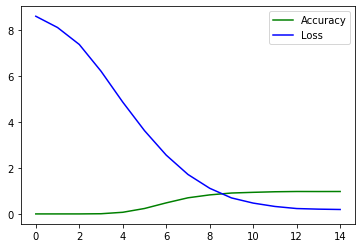

In [325]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g')
plt.plot(epochs, loss, 'b')
plt.legend(['Accuracy','Loss'])
plt.show()